Explicit Finite Differences Method for Option Valuation

Includes Call and Puts / American and European

In [1]:
import math
import numpy as np
import pandas as pd
import xlwings as xw
import scipy as sp
from scipy import stats
import matplotlib as plt

In [2]:
T = 1  #Time to Expiry in Years
E = 100  #Strike
r = .05  #Risk Free Rate
SIGMA = .20  #Volatility

#Up out Out Call - Set Barrier_Call to barrier value and set Type to True
#Down and Out Call - Set Barrier_Put to barrier value and set Type to True

#Down and Out Put - Set Barrier_Put to barrier value and set Type to False
#Up and Out Put - Set Barrier_Call to barrier value and set Type to False


Type = True   #Type of Option True=Call False=Put
Ex = False #Early Exercise True=Yes  False=No 
NAS = 100  #Number of Asset Steps - Higher is more accurate, but more time consuming
Barrier_Call = 120  #Ceiling value to Up and Out Barrier Options- Set to zero if not using
Barrier_Put  = 0  #Floor value for Down and Out Barrier Options - Set to zero if not using

In [3]:
#Up and Out Call
if Barrier_Call > 0 and Type ==True:
    ds = Barrier_Call / NAS  #Asset Value Step Size
#Down and Out Call
if Barrier_Put > 0 and Type ==True:
    ds = ds = 2 * E / NAS  #Asset Value Step Size
#Up and Out Put
if Barrier_Call > 0 and Type ==False:
    ds = Barrier_Call / NAS  #Asset Value Step Size
#Down and Out Put
if Barrier_Put > 0 and Type == False:
    ds = ds = 2 * E / NAS  #Asset Value Step Size

dt = (0.9/NAS/NAS/SIGMA/SIGMA)  #Time Step Size
NTS = int(T / dt) + 1  #Number of Time Steps
dt = T / NTS #Time Step Size
print("Asset Step Size %.2f Time Step Size %.2f Number of Time Steps %.2f Number of Asset Steps %.2f" %(ds, dt, NTS, NAS))

Asset Step Size 1.20 Time Step Size 0.00 Number of Time Steps 445.00 Number of Asset Steps 100.00


In [4]:
#Setup Empty numpy Arrays
value_matrix = np.zeros((int(NAS+1), int(NTS)))
asset_price = np.arange(NAS*ds,-1,-ds)

In [5]:
#Evaluate Terminal Value for Calls or Puts
if Type == True:
    value_matrix[:,-1]= np.maximum(asset_price - E,0)
else:
    value_matrix[:,-1]= np.maximum(E - asset_price,0)

In [6]:
#Set Lower Boundry in Grid
if Barrier_Put > 0:
    for x in range(1,NTS):
        value_matrix[-1,-x-1] = 0
else:
    for x in range(1,NTS):
        value_matrix[-1,-x-1] = value_matrix[-1,-x]* math.exp(-r*dt)

In [7]:
#Set Mid and Ceiling Values in Grid
for x in range(1,int(NTS)):

    for y in range(1,int(NAS)):
        #Evaluate Option Greeks
        Delta = (value_matrix[y-1,-x] - value_matrix[y+1,-x]) / 2 / ds
        Gamma = (value_matrix[y-1,-x] - (2 * value_matrix[y,-x]) + value_matrix[y+1,-x]) / ds / ds
        Theta = (-.5 * SIGMA**2 * asset_price[y]**2 * Gamma) - (r * asset_price[y] * Delta) + (r * value_matrix[y,-x])
        
        #Set Mid Values
        value_matrix[y,-x-1] = value_matrix[y,-x] - Theta * dt
        if Ex == True:
            value_matrix[y,-x-1] = np.maximum(value_matrix[y,-x-1], value_matrix[y,-1])
        if Barrier_Put > 0:
            if asset_price[y] < Barrier_Put:
                value_matrix[y,-x-1] = 0
          

        #Set Ceiling Value
        if Barrier_Call > 0:
            value_matrix[0,-x-1] = 0
        else:
            value_matrix[0,-x-1] = 2 * value_matrix[1,-x-1] - value_matrix[2,-x-1] 
        
#Export Value Grid to Excel via xlWings
#xw.view(value_matrix)

In [8]:
#Option Valuation Profile in pandas - Index is Strike Price, column 0 is the option price
value_df = pd.DataFrame(value_matrix)
value_df = value_df.set_index(asset_price)

#Export Value Grid to Excel via xlWings
#xw.view(value_df)

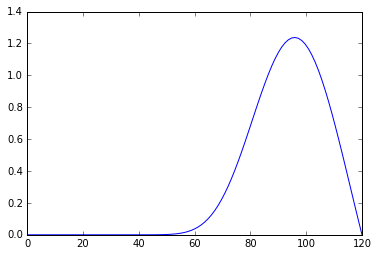

In [9]:
%matplotlib inline
#Payoff Plot
plot_df = value_df.sort_index(ascending=True)
plot_df[0].plot()